In [1]:
import pandas as pd
import numpy as np
import GetPoolData
import ResetStrategy
import ActiveStrategyFramework
import itertools

# Create config.py in this directory and enter your own Bitquery API Token
BITQUERY_API_TOKEN = "BQYLMaAji34bf0y8ce5Ow4chrpc6c9lV"

#################
#
# Download data
#
################

# Get Swap Data
DOWNLOAD_DATA      = False
address            = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
token_0_address    = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
token_1_address    = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'
flipside_queries   = ['https://api.flipsidecrypto.com/api/v2/queries/b8ad3087-803a-478b-9ed3-c4f3c096bc47/data/latest',
                      'https://api.flipsidecrypto.com/api/v2/queries/de277680-5ff6-4d58-bfff-29ef114215be/data/latest']

AGGREGATED_MINUTES = 60*24*3 # Works like a 'target' rebalance period

# Price data for theThese must be month ends
price_data_begin         = '2020-12-31'
price_data_end           = '2021-12-31'
file_name                = 'eth_usdc'

swap_data                = GetPoolData.get_pool_data_flipside(address,flipside_queries,file_name,DOWNLOAD_DATA)  
price_data               = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,file_name,DOWNLOAD_DATA)

# Use empirical CDF for extracting boundaries of strategy
model_data               = ActiveStrategyFramework.aggregate_price_data(price_data,AGGREGATED_MINUTES)

In [2]:
#################
#
# Run Reset Strategy
#
################

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-15 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-07-28 00:00PM',utc=True)


# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
import scipy
STRATEGY_FREQUENCY_MINUTES         = 1 # (has to be at least one minute)
simulate_data_filtered             = ActiveStrategyFramework.aggregate_price_data(price_data,STRATEGY_FREQUENCY_MINUTES)
simulate_data_filtered['z_scores'] = np.abs(scipy.stats.zscore(simulate_data_filtered['quotePrice']))
simulate_data_filtered             = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.z_scores) > 3].index)
simulate_data_filtered             = simulate_data_filtered.sort_index()
simulate_data_price                = simulate_data_filtered[DATE_BEGIN:DATE_END]['quotePrice']

# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18
swap_data['virtual_liquidity'] = swap_data['VIRTUAL_LIQUIDITY_ADJUSTED']*10**(DECIMALS_1  - DECIMALS_0)
swap_data['traded_in']         = swap_data.apply(lambda x: -x['amount0'] if (x['amount0'] < 0) else -x['amount1'],axis=1).astype(float)
swap_data['traded_out']        = swap_data.apply(lambda x:  x['amount0'] if (x['amount0'] > 0) else  x['amount1'],axis=1).astype(float)

# Strategy Parameters
alpha_range = [.90, .95]
tau_range   = [.90, .95]
limit_range = [.40, .50, .60]

sim_performance  = []
sim_results      = []

for j in list(itertools.product(alpha_range,tau_range,limit_range)):
    print(j)
    Reset_Strategy                   = ResetStrategy.ResetStrategy(model_data,j[0],j[1],j[2])
    simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,swap_data,Reset_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,Reset_Strategy)
    strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,INITIAL_POSITION_VALUE)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['limit_param']      = j[2]
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)

(0.9, 0.9, 0.4)
(0.9, 0.9, 0.5)
(0.9, 0.9, 0.6)
(0.9, 0.95, 0.4)
(0.9, 0.95, 0.5)
(0.9, 0.95, 0.6)
(0.95, 0.9, 0.4)
(0.95, 0.9, 0.5)
(0.95, 0.9, 0.6)
(0.95, 0.95, 0.4)
(0.95, 0.95, 0.5)
(0.95, 0.95, 0.6)


In [3]:
pd.DataFrame(sim_performance)

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param
0,13,0.890601,0.031720,1.377454,0.049060,7,0.115089,0.524517,2.626136,0.843903,0.982485,0.90,0.90,0.4
1,13,0.890601,0.031720,1.377454,0.049060,7,0.115089,0.524517,2.626136,0.843903,0.982485,0.90,0.90,0.5
2,13,0.890601,0.031720,1.377454,0.049060,7,0.115089,0.524517,2.626136,0.843903,0.982485,0.90,0.90,0.6
3,13,0.945035,0.033659,1.367856,0.048718,10,0.115018,0.528739,2.587013,0.873985,0.982485,0.90,0.95,0.4
4,13,0.945035,0.033659,1.367856,0.048718,10,0.115018,0.528739,2.587013,0.873985,0.982485,0.90,0.95,0.5
5,13,0.945035,0.033659,1.367856,0.048718,10,0.115018,0.528739,2.587013,0.873985,0.982485,0.90,0.95,0.6
6,13,0.757208,0.026969,1.531207,0.054536,7,0.115565,0.510780,2.997781,0.812843,0.919662,0.95,0.90,0.4
7,13,0.757208,0.026969,1.531207,0.054536,7,0.115565,0.510780,2.997781,0.812843,0.919662,0.95,0.90,0.5
8,13,0.757208,0.026969,1.531207,0.054536,7,0.115565,0.510780,2.997781,0.812843,0.919662,0.95,0.90,0.6
9,13,0.771407,0.027475,1.544521,0.055010,11,0.116036,0.511888,3.017301,0.816479,0.919662,0.95,0.95,0.4


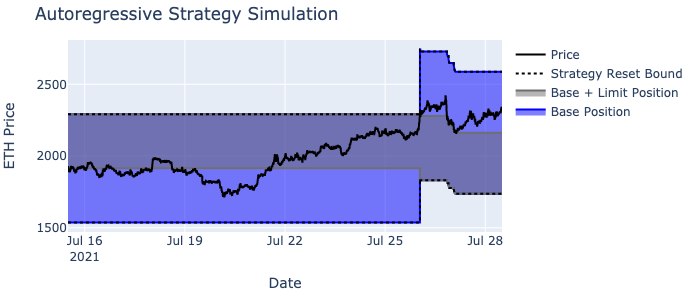

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

resulting_strat                      = sim_results[7] 
data_strategy                        = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,Reset_Strategy)
data_strategy['value_hold']          = INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * data_strategy['price_1_0']
data_strategy['relative_to_holding'] = data_strategy['value_position']/data_strategy['value_hold']-1
data_strategy['cum_fees_usd']        = data_strategy['token_0_fees'].cumsum() + (data_strategy['token_1_fees'] * data_strategy['price_1_0']).cumsum()
data_strategy['net_gain']            = (data_strategy['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE

ActiveStrategyFramework.plot_strategy(data_strategy,'ETH Price','#0000FF')